In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
jax.config.update("jax_platform_name", "cpu")

def grad_multi_gaussian(x: jax.Array) -> jax.Array:
    h: float=0.15
    sigma: float=0.5
    s: float=6.
    gaussian = lambda x, mu, std: jnp.exp(-0.5*((x-mu)/std)**2) # * 1/((2*jnp.pi)**(0.5) * std)
    return (1+h)*gaussian(x, 0, sigma) - h*gaussian(x, sigma, s*sigma) - h*gaussian(x, -sigma, s*sigma)

def grad_double_gelu(x: jax.Array) -> jax.Array:
    y1 = jnp.where(x < 0, jax.nn.gelu(x+1.1))
    y2 = jnp.where(x >= 0, jax.nn.gelu(-x+1.1))
    return y1 + y2

x = jnp.linspace(-10, 10, 1000)
fig, ax = plt.subplots(1, 1)
ax.plot(x, grad_multi_gaussian(x), label="multi gaussian")
ax.plot(x, grad_double_gelu(x), label="double gelu")
fig.legend()
plt.show()

2024-07-03 15:26:30.304368: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-07-03 15:26:30.304694: E external/xla/xla/stream_executor/cuda/cuda_diagnostics.cc:252] kernel version 535.171.4 does not match DSO version 535.183.1 -- cannot find working devices in this configuration


RuntimeError: Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices. (you may need to uninstall the failing plugin package, or set JAX_PLATFORMS=cpu to skip this backend.)

In [1]:
# sets the correct path, don't know how to toggle this once it is set
%cd ../
%pwd

/home/thomas/Development/resonator-hackathon/ssm/equinox


/home/thomas/Development/resonator-hackathon/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/thomas/Development/resonator-hackathon/ssm/equinox'

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
import jax 
import jax.numpy as jnp
import equinox as eqx
import optax
from tqdm import tqdm
from typing import Callable
import wandb
import math
import numpy as np

from resonator_s5.classifier import Classifier
from functools import partial

import tonic
import tonic.transforms as transforms
from tonic import DiskCachedDataset


def downsample(x: np.ndarray) -> np.ndarray:
    """
    Input: (T, 700)
    Output: (T, 140)
    """
    x = x.reshape((-1, 14, 50))
    x = x.sum(axis=-1)
    return x


shd_sensor_size = (700, 1, 1)
bins = 250
pre_cache_transform = transforms.Compose([
    # tonic.transforms.ToFrame(
    #     sensor_size=(700, 1, 1), # ssc.sensor_size = (700, 1, 1) 
    #     time_window=1000,
    # ),
    # tonic.transforms.CropTime(max=100000),
    tonic.transforms.Downsample(sensor_size=shd_sensor_size, target_size=(140, 1)),
])
post_cache_train_transform = transforms.Compose([
    # tonic.transforms.UniformNoise(sensor_size=shd_sensor_size, n=1000),
    # tonic.transforms.SpatialJitter(
    #         sensor_size=shd_sensor_size, 
    #         var_x=1, 
    #         var_y=1, 
    #         clip_outliers=True
    #     ),
    tonic.transforms.TimeJitter(std=100, clip_negative=True),
    # tonic.transforms.DropEvent(p=0.33),
    tonic.transforms.ToFrame(
        sensor_size=(140, 1, 1), 
        n_time_bins=bins,
    ),
    torchvision.transforms.Lambda(lambda x: x[:, 0, :]),
    torchvision.transforms.Lambda(lambda x: (x > 0).astype(np.int32)),
])
post_cache_val_transform = transforms.Compose([
    # tonic.transforms.UniformNoise(sensor_size=shd_sensor_size, n=1000),
    # tonic.transforms.SpatialJitter(
    #         sensor_size=shd_sensor_size, 
    #         var_x=1, 
    #         var_y=1, 
    #         clip_outliers=True
    #     ),
    # tonic.transforms.TimeJitter(std=100, clip_negative=True),
    # tonic.transforms.DropEvent(p=0.33),
    tonic.transforms.ToFrame(
        sensor_size=(140, 1, 1), 
        n_time_bins=bins,
    ),
    torchvision.transforms.Lambda(lambda x: x[:, 0, :]),
    torchvision.transforms.Lambda(lambda x: (x > 0).astype(np.int32)),
])


train_dataset = tonic.datasets.SSC(save_to="../../data", split="train", transform=pre_cache_transform)
val_dataset = tonic.datasets.SSC(save_to="../../data", split="valid", transform=pre_cache_transform)
test_dataset = tonic.datasets.SSC(save_to="../../data", split="test", transform=pre_cache_transform)

train_dataset = DiskCachedDataset(train_dataset, cache_path="../../data/tonic/cache/ssc/train", transform=post_cache_train_transform)
val_dataset = DiskCachedDataset(val_dataset, cache_path="../../data/tonic/cache/ssc/val", transform=post_cache_val_transform)
test_dataset = DiskCachedDataset(test_dataset, cache_path="../../data/tonic/cache/ssc/test", transform=post_cache_val_transform)


BATCH_SIZE = 64
NUM_CLASSES = 35
EPOCHS = 40

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

/home/thomas/Development/resonator-hackathon/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
x, y = next(iter(train_dataloader))
x.shape

torch.Size([64, 250, 140])

In [4]:
rng_key = jax.random.PRNGKey(42)
rng_key, model_key = jax.random.split(rng_key, num=2)

model = Classifier(
    rng_key=model_key,
    input_dim=140,
    output_dim=NUM_CLASSES,
    num_neurons=[128]*6,
    # num_neurons=[4],
    num_blocks=[16]*6,
    # num_blocks=[1],
    dt_min=0.001,
    dt_max=0.1,
    activation="cartesian_spike",
    discretization="zoh",
    bidirectional=False,
    keep_imag=True,
    v_pos="before_spike",
    apply_skip=True,
    dropout=0.2,
    dense_dropout = False,
)
model

2024-06-18 20:40:11.552223: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Classifier(
  dense_layers=[
    RFDense(
      C=f32[128,140,2],
      keep_imag=True,
      norm=RadialNorm(
        norm=LayerNorm(
          shape=(128,),
          eps=1e-05,
          use_weight=True,
          use_bias=True,
          weight=f32[128],
          bias=f32[128]
        ),
        keep_imag=True
      )
    ),
    RFDense(
      C=f32[128,128,2],
      keep_imag=True,
      norm=RadialNorm(
        norm=LayerNorm(
          shape=(128,),
          eps=1e-05,
          use_weight=True,
          use_bias=True,
          weight=f32[128],
          bias=f32[128]
        ),
        keep_imag=True
      )
    ),
    RFDense(
      C=f32[128,128,2],
      keep_imag=True,
      norm=RadialNorm(
        norm=LayerNorm(
          shape=(128,),
          eps=1e-05,
          use_weight=True,
          use_bias=True,
          weight=f32[128],
          bias=f32[128]
        ),
        keep_imag=True
      )
    ),
    RFDense(
      C=f32[128,128,2],
      keep_imag=True,
   

In [5]:
model.neuron_layers[0].Lambda[...,1]

Array([-19.857405  ,  -5.3542137 ,  -1.9577932 ,  -0.427489  ,
         0.42748874,   1.9577956 ,   5.354209  ,  19.85741   ,
       -19.857405  ,  -5.3542137 ,  -1.9577932 ,  -0.427489  ,
         0.42748874,   1.9577956 ,   5.354209  ,  19.85741   ,
       -19.857405  ,  -5.3542137 ,  -1.9577932 ,  -0.427489  ,
         0.42748874,   1.9577956 ,   5.354209  ,  19.85741   ,
       -19.857405  ,  -5.3542137 ,  -1.9577932 ,  -0.427489  ,
         0.42748874,   1.9577956 ,   5.354209  ,  19.85741   ,
       -19.857405  ,  -5.3542137 ,  -1.9577932 ,  -0.427489  ,
         0.42748874,   1.9577956 ,   5.354209  ,  19.85741   ,
       -19.857405  ,  -5.3542137 ,  -1.9577932 ,  -0.427489  ,
         0.42748874,   1.9577956 ,   5.354209  ,  19.85741   ,
       -19.857405  ,  -5.3542137 ,  -1.9577932 ,  -0.427489  ,
         0.42748874,   1.9577956 ,   5.354209  ,  19.85741   ,
       -19.857405  ,  -5.3542137 ,  -1.9577932 ,  -0.427489  ,
         0.42748874,   1.9577956 ,   5.354209  ,  19.85

In [6]:
jnp.exp(model.forward(jnp.ones([4, 140]), rng_key=rng_key))

Array([0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
       0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
       0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
       0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
       0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
       0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
       0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143],      dtype=float32)

In [7]:
from resonator_s5.optax_helper import init_optimizer

decay_steps = EPOCHS * len(train_dataloader)
# if PERMUTE:
# standard_lr = 0.004
# ssm_lr = 0.001
# else:
standard_lr = 0.004
ssm_lr = 0.004

optim, opt_state = init_optimizer(model, standard_lr=standard_lr, ssm_lr=ssm_lr, weight_decay=0.0001, decay_steps=decay_steps)

In [8]:
opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate']

Array(0.004, dtype=float32)

In [9]:
def loss_fn(model: Classifier, train_key, x: jax.Array, y: jax.Array):
    call = partial(model.forward, rng_key=train_key)
    batched_model = jax.vmap(call, in_axes=(0), out_axes=(0)) # add batch dim to x only
    logits = batched_model(x)
    loss = optax.softmax_cross_entropy(logits=logits, labels=y)
    loss = loss.mean()
    return loss, (logits)


# x , y = next(iter(test_dataloader))
# x = jnp.asarray(x.numpy())
# y = jnp.asarray(y.numpy())

# value, grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model, rng_key, x, y)

# lrs = []
# for _ in tqdm(range(1080)):
#     updates, opt_state = optim.update(grads, opt_state, model)
#     lr = opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate']
#     lrs.append(lr)

# model = eqx.apply_updates(model, updates)

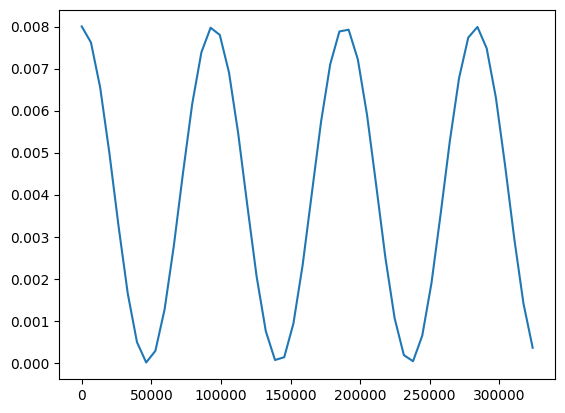

In [10]:
import matplotlib.pyplot as plt
x = jnp.linspace(0, 1080*300)
y = 0.008 * (1-1e-6)/2 * (1 + jnp.cos(jnp.pi * x/decay_steps)) + 1e-6
plt.plot(x, y)

In [11]:
opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate']

Array(0.004, dtype=float32)

In [12]:
import numpy as np

x = np.array([2, 1])
np.all(x != 0)

True

In [13]:
# @jax.jit
def cut_mix(x: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Performs cut mix augmentation: https://arxiv.org/pdf/1905.04899 but for a sequence.
    Code is deliberately in numpy and not jax.numpy cause it is simpler to work on mutable arrays.
    Input:
        x: (B, T, C)
        y: (B, 1)
    Output:
        x: (B, T, C)
        y: (B, 1)
    """
    B = x.shape[0]
    T = x.shape[1]
    success = False
    while not success:
        lmbda = np.random.uniform(low=0, high=1)
        rand_index = np.random.permutation(np.arange(B))
        
        t1 = np.random.randint(low=0, high=T)
        t2 = int(T * (1-lmbda))
        
        t1_cut = np.clip((t1 - t2) // 2, a_min=0, a_max=T)
        t2_cut = np.clip((t1 + t2) // 2, a_min=0, a_max=T)

        # lmbda = 1 - t2/T
        num_spikes2 = x[rand_index, t1_cut:t2_cut, :].sum(axis=(1, 2))
        num_spikes1 = x.sum(axis=(1, 2)) - x[:, t1_cut:t2_cut, :].sum(axis=(1, 2))

        success = np.all((num_spikes2 + num_spikes1) != 0)

    x[:, t1_cut:t2_cut, :] = x[rand_index, t1_cut:t2_cut, :]
    
    lmbda = num_spikes1 / (num_spikes1 + num_spikes2)
    lmbda = lmbda[:, None]
    y = lmbda * y + (1-lmbda) * y[rand_index]
    return x, y

# @jax.jit
def one_hot(x: np.ndarray) -> np.ndarray:
    """
    Input: (B)
    Output: (B)
    """
    # x = x[:, 0]
    x = np.eye(NUM_CLASSES)[x]
    # x = x[:, None]
    return x 


def prep_data(x: torch.Tensor, y: torch.Tensor, training: bool) -> tuple[jax.Array, jax.Array]:
    x = x.numpy()
    y = y.numpy()
    y = one_hot(y)
    if training: 
        x, y = cut_mix(x, y)
    x = jnp.asarray(x)
    y = jnp.asarray(y)
    return x, y

In [14]:
x = np.arange(10)
np.clip(a=x, a_min=np.ones_like(x), a_max=x)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [15]:
np.stack([np.arange(10), np.ones(10)]).max(axis=0)

array([1., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [16]:
@eqx.filter_jit
def train_step(model: Classifier, train_key, opt_state, x: jax.Array, y: jax.Array):
    (loss_value, (logits)), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model, train_key, x, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    metrics = {
        'loss': loss_value,
        'accuracy': jnp.mean(jnp.argmax(logits, axis=-1) == jnp.argmax(y, axis=-1)),
    }
    return model, opt_state, metrics


@eqx.filter_jit
def test_step(model: Classifier, rng_key, x, y):
    loss_value, (logits) = loss_fn(model, rng_key, x, y)
    metrics = {
        'loss': loss_value,
        # 'accuracy': jnp.mean(jnp.argmax(logits, -1) == y),
        'accuracy': jnp.mean(jnp.argmax(logits, axis=-1) == jnp.argmax(y, axis=-1)),
    }
    return metrics


@eqx.filter_jit
def get_average_spikes(model: Classifier, x: jax.Array, layer: int) -> tuple[jax.Array, jax.Array]:
    spikes_fn = partial(model.gen_spikes, layer=layer)
    spikes = jax.vmap(spikes_fn)(x)
    return (jnp.sum(spikes) / BATCH_SIZE).astype(jnp.int32), jnp.mean(spikes)


def train_epoch(model: Classifier, rng_key, opt_state, track_layer: int):
    train_metrics = {
        'loss': [],
        'accuracy': [],
    }
    val_metrics = {
        'loss': [],
        'accuracy': [],
        'num_spikes': [],
        'avg_spikes': [],
    }
    test_metrics = {
        'loss': [],
        'accuracy': [],
        'num_spikes': [],
        'avg_spikes': [],
    }
    print("training")
    for x, y in tqdm(train_dataloader):
        x, y = prep_data(x, y, training=True)
        rng_key, train_key = jax.random.split(rng_key, num=2)
        model, opt_state, metric = train_step(model, train_key, opt_state, x, y)
        train_metrics['loss'].append(metric['loss'])
        train_metrics['accuracy'].append(metric['accuracy'])

        # wandb.log({
        #      "loss": metric["loss"],
        #      "acc": metric["accuracy"],
        # })
    
    print("validating")
    inference_model = eqx.nn.inference_mode(model)
    for x, y in tqdm(val_dataloader): 
        x, y = prep_data(x, y, training=False)
        metric = test_step(inference_model, rng_key, x, y)
        val_metrics['loss'].append(metric['loss'])
        val_metrics['accuracy'].append(metric['accuracy'])

    num_spikes, avg_spikes = get_average_spikes(model, x, layer=track_layer)
    val_metrics['num_spikes'] = num_spikes
    val_metrics['avg_spikes'] = avg_spikes

    print("testing")
    for x, y in tqdm(test_dataloader): 
        x, y = prep_data(x, y, training=False)
        metric = test_step(inference_model, rng_key, x, y)
        test_metrics['loss'].append(metric['loss'])
        test_metrics['accuracy'].append(metric['accuracy'])
    
    num_spikes, avg_spikes = get_average_spikes(model, x, layer=track_layer)
    test_metrics['num_spikes'] = num_spikes
    test_metrics['avg_spikes'] = avg_spikes

    train_metrics['loss'] = jnp.array(train_metrics['loss']).mean()
    train_metrics['accuracy'] = jnp.array(train_metrics['accuracy']).mean()
    val_metrics['loss'] = jnp.array(val_metrics['loss']).mean()
    val_metrics['accuracy'] = jnp.array(val_metrics['accuracy']).mean()
    test_metrics['loss'] = jnp.array(test_metrics['loss']).mean()
    test_metrics['accuracy'] = jnp.array(test_metrics['accuracy']).mean()

    print(f"Train Loss: {train_metrics['loss']}")
    print(f"Train Acc: {train_metrics['accuracy']}")
    print(f"Val Loss: {val_metrics['loss']}")
    print(f"Val Acc: {val_metrics['accuracy']}")
    print(f"Test Loss: {test_metrics['loss']}")
    print(f"Test Acc: {test_metrics['accuracy']}\n")

    return model, opt_state, train_metrics, val_metrics, test_metrics

In [17]:
class BestAccTracker:
    def __init__(self) -> None:
        self.counter = 0
        self.best_acc = 0
    
    def update(self, x: jax.Array | float) -> None:
        if x > self.best_acc:
            self.best_acc = x
            self.reset_counter()
        else:
            self.counter += 1
    
    def reset_counter(self) -> None:
        self.counter = 0



some_nan = lambda x: np.sum(np.isnan(x)) > 0

In [18]:
from IPython.display import clear_output

wandb.init(project="S5_SSC")

rng_key = jax.random.PRNGKey(42)
tracker = BestAccTracker()
track_layer = 0
for epoch in range(EPOCHS):
    if (epoch % 5) == 0: 
        clear_output(wait=True)
    print(f"Epoch: {epoch+1}/{EPOCHS}")
    model, opt_state, train_metrics, val_metrics, test_metrics = train_epoch(model, rng_key, opt_state, track_layer=track_layer)
    tracker.update(val_metrics["accuracy"])

    wandb.log({
        "Train Loss": train_metrics['loss'], 
        "Train Accuracy": train_metrics['accuracy'], 
        "Val Loss": val_metrics['loss'], 
        "Val Accuracy": val_metrics['accuracy'],
        "Test Loss": test_metrics['loss'], 
        "Test Accuracy": test_metrics['accuracy'],
        "Max Lambda real": -jnp.exp(model.neuron_layers[track_layer].Lambda[...,0].min()),
        "Min Lambda real": -jnp.exp(model.neuron_layers[track_layer].Lambda[...,0].max()),
        "Max Lambda imag": model.neuron_layers[track_layer].Lambda[...,1].max(),
        "Min Lambda imag": model.neuron_layers[track_layer].Lambda[...,1].min(),
        "Max C real": model.dense_layers[track_layer].C[...,0].max(),
        "Min C real": model.dense_layers[track_layer].C[...,0].min(),
        "Max C imag": model.dense_layers[track_layer].C[...,1].max(),
        "Min C imag": model.dense_layers[track_layer].C[...,1].min(),
        "Max Delta": jnp.exp(model.neuron_layers[track_layer].log_step.max()),
        "Min Delta": jnp.exp(model.neuron_layers[track_layer].log_step.min()),
        "Val Num Spikes": val_metrics['num_spikes'], 
        "Val Avg Spikes": val_metrics['avg_spikes'],
        "Test Num Spikes": test_metrics['num_spikes'], 
        "Test Avg Spikes": test_metrics['avg_spikes'],
        "Learning Rate Standard": opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate'],
        "Learning Rate SSM": opt_state.inner_states['ssm'].inner_state.hyperparams['learning_rate'],
        "Counter": tracker.counter,
        "Max Tau": jnp.exp(model.li.tau.max()),
        "Min Tau": jnp.exp(model.li.tau.min()),
        }
    )

    if tracker.counter >= 20:
        lr_standard = opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate']
        lr_ssm = opt_state.inner_states['ssm'].inner_state.hyperparams['learning_rate']
        lr_standard = max(0.2 * lr_standard, 1e-6) 
        lr_ssm = max(0.2 * lr_ssm, 1e-6)
        opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate'] = lr_standard
        opt_state.inner_states['ssm'].inner_state.hyperparams['learning_rate'] = lr_ssm
        tracker.reset_counter()

    if some_nan(model.neuron_layers[track_layer].Lambda):
        print("Lambda nan")
        break
    if some_nan(model.dense_layers[track_layer].C):
        print("C nan")
        break
    if some_nan(model.neuron_layers[track_layer].log_step):
        print("Delta nan")
        break

wandb.finish()

Epoch: 36/40
training


100%|██████████| 1180/1180 [03:38<00:00,  5.39it/s]


validating


100%|██████████| 156/156 [00:24<00:00,  6.37it/s]


testing


100%|██████████| 319/319 [00:50<00:00,  6.32it/s]


Train Loss: 1.8907749652862549
Train Acc: 0.5677251219749451
Val Loss: 0.9449732899665833
Val Acc: 0.7369956374168396
Test Loss: 0.9973435401916504
Test Acc: 0.7210912704467773

Epoch: 37/40
training


100%|██████████| 1180/1180 [03:40<00:00,  5.36it/s]


validating


100%|██████████| 156/156 [00:24<00:00,  6.32it/s]


testing


100%|██████████| 319/319 [00:50<00:00,  6.33it/s]


Train Loss: 1.8831005096435547
Train Acc: 0.568606972694397
Val Loss: 0.9365272521972656
Val Acc: 0.739489734172821
Test Loss: 0.9889496564865112
Test Acc: 0.722315788269043

Epoch: 38/40
training


100%|██████████| 1180/1180 [03:42<00:00,  5.31it/s]


validating


100%|██████████| 156/156 [00:24<00:00,  6.31it/s]


testing


100%|██████████| 319/319 [00:51<00:00,  6.24it/s]


Train Loss: 1.8890082836151123
Train Acc: 0.5696371793746948
Val Loss: 0.9351481795310974
Val Acc: 0.7401054501533508
Test Loss: 0.9884647130966187
Test Acc: 0.7217345833778381

Epoch: 39/40
training


100%|██████████| 1180/1180 [03:43<00:00,  5.28it/s]


validating


100%|██████████| 156/156 [00:25<00:00,  6.21it/s]


testing


100%|██████████| 319/319 [00:51<00:00,  6.22it/s]


Train Loss: 1.8880962133407593
Train Acc: 0.5721795558929443
Val Loss: 0.9339594841003418
Val Acc: 0.7393994331359863
Test Loss: 0.987754762172699
Test Acc: 0.7223713397979736

Epoch: 40/40
training


100%|██████████| 1180/1180 [03:42<00:00,  5.30it/s]


validating


100%|██████████| 156/156 [00:25<00:00,  6.23it/s]


testing


100%|██████████| 319/319 [00:51<00:00,  6.25it/s]


Train Loss: 1.8990693092346191
Train Acc: 0.5683712363243103
Val Loss: 0.9362149238586426
Val Acc: 0.7399002313613892
Test Loss: 0.9872126579284668
Test Acc: 0.7220774292945862



Counter,▁▁▁▁▁▁▁▁▂▁▁▂▁▂▁▁▂▄▁▁▁▂▁▁▂▁▂▄▁▂▄▁▂▄▁▂▄▅▇█
Learning Rate SSM,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Learning Rate Standard,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Max C imag,▁▂▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████████████████
Max C real,▁▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████
Max Delta,▁▃▆▇▇▇▇▇▇▇▇▇██▇█████████████████████████
Max Lambda imag,▁▂▂▄▃▄▃▅▇▆▅▆▆██▇▇▇▇▇▇▇▇███▇▇▇▇▇██▇██████
Max Lambda real,▇▁▂▃▅▇█▇█▇▇▇▇██▇▇▇▆▆▆▆▆▄▃▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂
Max Tau,▁▃▄▅▄▇▇▇▇▆▇▆▇▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Min C imag,█▇▆▆▅▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Min C real,██▇▆▆▆▅▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [19]:
wandb.finish()

In [20]:
opt_state.inner_states['standard'].inner_state#.hyperparams['learning_rate']

InjectStatefulHyperparamsState(count=Array(47200, dtype=int32), hyperparams={'b1': Array(0.9, dtype=float32), 'b2': Array(0.999, dtype=float32), 'eps': Array(1.e-08, dtype=float32), 'eps_root': Array(0., dtype=float32), 'learning_rate': Array(4.0000003e-09, dtype=float32), 'weight_decay': Array(1.e-04, dtype=float32)}, hyperparams_states={'learning_rate': WrappedScheduleState(count=Array(47200, dtype=int32))}, inner_state=(ScaleByAdamState(count=Array(47200, dtype=int32), mu=Classifier(
  dense_layers=[
    RFDense(
      C=f32[128,140,2],
      keep_imag=None,
      norm=RadialNorm(
        norm=LayerNorm(
          shape=(128,),
          eps=1e-05,
          use_weight=True,
          use_bias=True,
          weight=f32[128],
          bias=f32[128]
        ),
        keep_imag=None
      )
    ),
    RFDense(
      C=f32[128,128,2],
      keep_imag=None,
      norm=RadialNorm(
        norm=LayerNorm(
          shape=(128,),
          eps=1e-05,
          use_weight=True,
          

In [21]:
model.dense_layers[0].C

Array([[[ 0.5612016 ,  0.24061255],
        [ 0.09483978,  0.18571655],
        [-0.14064732,  1.1366497 ],
        ...,
        [-0.12996866, -0.49846843],
        [ 0.5404331 , -0.8442935 ],
        [-0.07383841, -1.1170496 ]],

       [[-0.8365227 , -0.57221526],
        [-0.22534093,  0.858842  ],
        [ 1.7784208 , -0.7163357 ],
        ...,
        [-0.00929436,  0.32410818],
        [ 0.30637085,  0.35014072],
        [-0.21457562,  0.70076746]],

       [[ 0.0574888 , -0.8637586 ],
        [-0.64097637, -1.2214905 ],
        [ 1.0241233 , -0.99533176],
        ...,
        [ 0.4151726 ,  0.37747246],
        [-0.07557665,  0.8084335 ],
        [ 0.08066111,  0.6787049 ]],

       ...,

       [[-0.02335975, -0.01589949],
        [ 1.0454738 ,  0.15441346],
        [ 0.6679944 ,  0.12644981],
        ...,
        [ 0.890263  , -0.18520698],
        [ 1.2244103 , -0.5750573 ],
        [ 0.90659887, -0.8349935 ]],

       [[-0.12791693, -0.9422269 ],
        [ 0.13146015,  0.21

In [22]:
model.neuron_layers[0].log_step

Array([[-3.446196 ],
       [-4.0523095],
       [-7.414656 ],
       [-5.1316743],
       [-1.3078438],
       [-2.9639528],
       [-4.534997 ],
       [-4.8199096],
       [-3.684426 ],
       [-2.5869176],
       [-2.8252864],
       [-7.1607327],
       [-6.4738727],
       [-1.9090204],
       [-5.038769 ],
       [-5.634285 ],
       [-4.373396 ],
       [-3.2266722],
       [-3.5400832],
       [-6.808921 ],
       [-5.312518 ],
       [-2.4331856],
       [-5.678553 ],
       [-6.637503 ],
       [-3.8560238],
       [-3.8020449],
       [-5.8722577],
       [-5.9108486],
       [-5.7063017],
       [-2.7967448],
       [-4.461726 ],
       [-5.138158 ],
       [-3.979386 ],
       [-6.501038 ],
       [-2.7595172],
       [-2.5429664],
       [-6.3601737],
       [-2.4241514],
       [-3.5795934],
       [-3.5895524],
       [-5.7809215],
       [-2.6502302],
       [-3.5499427],
       [-6.4383698],
       [-1.4990965],
       [-2.0045643],
       [-5.1629157],
       [-4.13

In [23]:
model.neuron_layers[0].Lambda

Array([[  1.9329531 , -19.100328  ],
       [  1.2198097 ,  -5.619456  ],
       [  1.0152681 ,  -2.4111097 ],
       [  2.0834892 ,  -1.036959  ],
       [  0.3605228 ,   0.7464873 ],
       [  0.8492885 ,   2.7275515 ],
       [  1.1237726 ,   5.6097946 ],
       [  1.7914962 ,  19.989573  ],
       [  1.0130281 , -19.755547  ],
       [  1.0444394 ,  -5.11604   ],
       [  0.5557074 ,  -2.3900132 ],
       [  0.555835  ,   1.0623438 ],
       [  1.9873435 ,   1.8435651 ],
       [  0.15442324,   2.1219215 ],
       [  1.7716149 ,   5.1477413 ],
       [  1.8913652 ,  19.421059  ],
       [  1.2105979 , -19.425982  ],
       [  0.49248794,  -5.362897  ],
       [  0.1957226 ,  -3.0087101 ],
       [  1.585769  ,  -1.1395358 ],
       [  2.035081  ,   1.4296837 ],
       [  0.17942618,   3.2882044 ],
       [  1.8872374 ,   5.8967533 ],
       [  1.1169449 ,  20.311756  ],
       [  1.4086263 , -19.145153  ],
       [  0.79197246,  -5.917852  ],
       [  1.6169649 ,  -2.0988743 ],
 

In [24]:
raise Exception()

Exception: 

# Plots for Surrogat Gradients

In [ ]:
import matplotlib.pyplot as plt

x = jnp.linspace(-3, 3, 100)
h = 0.15
s = 6
sigma = 0.5
theta = 0
gaussian1 = lambda x, mu, std: jnp.exp(-0.5*((x-mu)/std)**2)

df1 = (1+h)*gaussian1(x, theta, sigma) - 2*h*gaussian1(x, theta, s*sigma)

plt.plot(x, df1)

In [ ]:
import matplotlib.pyplot as plt

x = jnp.linspace(-3, 3, 100)
h = 0.15
s = 6
sigma = 0.5
theta = 0
gaussian2 = lambda x, mu, std: 1/((2*jnp.pi)**(0.5) * std) * jnp.exp(-0.5*((x-mu)/std)**2)

df2 = (1+h)*gaussian2(x, theta, sigma) - h*gaussian2(x, sigma, s*sigma) - h*gaussian2(x, -sigma, s*sigma)

plt.plot(x, df2)

In [ ]:
import matplotlib.pyplot as plt

x = jnp.linspace(-3, 3, 100)
h = 0.15
s = 6
sigma = 0.5
theta = 0
gaussian2 = lambda x, mu, std: 1/((2*jnp.pi)**(0.5) * std) * jnp.exp(-0.5*((x-mu)/std)**2)

df3 = (4 / (jnp.exp(-x) + jnp.exp(x))**2).astype(jnp.float32)

plt.plot(x, df3)

In [ ]:
df1

In [ ]:
df2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

P0 = lambda x: np.ones_like(x)
P1 = lambda x: x
P2 = lambda x: (1/2) * (3 * x**2 - 1)
P3 = lambda x: (1/2) * (5 * x**3 - 3*x)
P4 = lambda x: (1/8) * (35 * x**4 - 30*x**2 + 3)
P5 = lambda x: (1/8) * (63 * x**5 - 70*x**3 + 15*x)
P6 = lambda x: (1/16) * (231 * x**6 - 315*x**4 + 105*x**2-5)

factor = lambda n: (2*n+1) / 2

x = np.linspace(-6, 6, 100)
x0 = 0.5
y = factor(0)*P0(x0)*P0(x) * factor(1)*P1(x0)*P1(x) * factor(2)*P2(x0)*P2(x) * factor(3)*P3(x0)*P3(x) * factor(4)*P4(x0)*P4(x) * factor(5)*P5(x0)*P5(x) * factor(6)*P6(x0)*P6(x)

In [ ]:
plt.plot(x, y)

In [ ]:
plt.plot(x, P6(x))

In [ ]:
def sin(m, x):
    # return 2**(0.5) * np.sin(2*np.pi * m * x)
    return np.sin(2*np.pi * m * x)

def cos(m, x):
    # return 2**(0.5) * np.cos(2*np.pi * m * x)
    return np.cos(2*np.pi * m * x)

def basis(n, x):
    if np.abs(n) % 2 == 0:
        return sin(n/2, x)
    else:
        return cos(int(n/2), x)


x = np.linspace(-5, 5, 100)
x0 = 2.1
y = np.sum(np.array([basis(n, x0) * basis(n, x) for n in range(-64, 64, 1)]), axis=0)

In [ ]:
plt.plot(x, y)

In [ ]:
y = [0, 0, 1, 0, 0]
np.fft.fft(y*2)